<!-- ABSTRACT -->

With this script, we evaluate the ensembles and check how well they perform. The result is a plot of the uncertainty of the model's predictions. However, it seems that the uncertainty is not very high.

In [1]:
import os
import sys
import numpy as np
import json
import joblib
import geopandas as gpd
import torch
import tqdm
import help_functions as hf

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

from gnn_architecture import MyGnn, mc_dropout_predict
import help_functions as hf

In [2]:
# Paths
runs_path = '../../data/runs_01_2025/'
ensembles = ["ensemble_1",
             "ensemble_2",
             "ensemble_3",
             "ensemble_4_lrz",
             "ensemble_5"]

# Dropout for Ensembles
use_dropout = [False,
               False,
               False,
               True,
               True]

districts = gpd.read_file("../../data/visualisation/districts_paris.geojson")
base_case_path = '../../data/links_and_stats/pop_1pct_basecase_average_output_links.geojson'

# GNN Parameters
point_net_conv_layer_structure_local_mlp = "256"
point_net_conv_layer_structure_global_mlp = "512"
gat_conv_layer_structure = "128,256,512"
predict_mode_stats = False
in_channels = 5
out_channels = 1

point_net_conv_layer_structure_local_mlp = [int(x) for x in point_net_conv_layer_structure_local_mlp.split(',')]
point_net_conv_layer_structure_global_mlp = [int(x) for x in point_net_conv_layer_structure_global_mlp.split(',')]
gat_conv_layer_structure = [int(x) for x in gat_conv_layer_structure.split(',')]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fct = torch.nn.MSELoss().to(dtype=torch.float32).to(device)

In [3]:
# Load test set and scalers
# Same for each ensemble with seed=42

ensemble_path = os.path.join(runs_path, ensembles[0])
data_created_during_training = os.path.join(ensemble_path, 'data_created_during_training/')

# Load scalers
scaler_x = joblib.load(data_created_during_training + 'test_x_scaler.pkl')
scaler_pos = joblib.load(data_created_during_training + 'test_pos_scaler.pkl')

# Load the test dataset created during training
test_set_dl = torch.load(data_created_during_training + 'test_dl.pt')

# Load the DataLoader parameters
with open(data_created_during_training + 'test_loader_params.json', 'r') as f:
    test_set_dl_loader_params = json.load(f)
    
# Remove or correct collate_fn if it is incorrectly specified
if 'collate_fn' in test_set_dl_loader_params and isinstance(test_set_dl_loader_params['collate_fn'], str):
    del test_set_dl_loader_params['collate_fn']  # Remove it to use the default collate function
    
test_set_loader = torch.utils.data.DataLoader(test_set_dl, **test_set_dl_loader_params)

In [4]:
def load_ensemble(ensemble, model_path, use_dropout):

    model = MyGnn(in_channels=in_channels, out_channels=out_channels,
                  point_net_conv_layer_structure_local_mlp=point_net_conv_layer_structure_local_mlp, 
                  point_net_conv_layer_structure_global_mlp = point_net_conv_layer_structure_global_mlp,
                  gat_conv_layer_structure=gat_conv_layer_structure,
                  use_dropout=use_dropout,
                 verbose=False)
    
    model = model.to(device)
    model.load_state_dict(torch.load(model_path))

    return model

In [5]:
for i, ensemble in enumerate(ensembles):

    model_path = os.path.join(runs_path, ensemble, 'trained_model/model.pth')
    model = load_ensemble(ensemble, model_path, use_dropout[i])
    
    test_loss, r_squared, actual_vals, predictions, baseline_loss = hf.validate_model_on_test_set(model, test_set_loader.dataset, loss_fct, device)

    print(f"\n{ensemble}:")
    print(f"Test Loss: {test_loss}")
    print(f"R-squared: {r_squared}")
    print(f"Baseline Loss: {baseline_loss}")

/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")



ensemble_1:
Test Loss: 25.425977328193746
R-squared: 0.7585934400558472
Baseline Loss: 105.32430267333984

ensemble_2:
Test Loss: 37.18775427986999
R-squared: 0.6469213962554932
Baseline Loss: 105.32430267333984

ensemble_3:
Test Loss: 40.13008401597593
R-squared: 0.6189855337142944
Baseline Loss: 105.32430267333984

ensemble_4_lrz:
Test Loss: 37.272034017331045
R-squared: 0.6461212635040283
Baseline Loss: 105.32430267333984

ensemble_5:
Test Loss: 37.83286069532594
R-squared: 0.6407964825630188
Baseline Loss: 105.32430267333984


In [6]:
def compute_bias_variance(actual_values, ensemble_predictions):
    """
    Compute bias and variance from ensemble predictions
    
    Parameters:
    - actual_values: numpy array of true values
    - ensemble_predictions: numpy array of shape (n_ensembles, n_samples)
    
    Returns:
    - bias: average bias (squared difference between mean prediction and true values)
    - variance: average variance of predictions
    """
    mean_predictions = np.mean(ensemble_predictions, axis=0)
    
    # Compute bias (squared difference between mean prediction and true value)
    bias = np.mean((mean_predictions - actual_values) ** 2)
    
    # Compute variance (average variance of predictions across ensemble members)
    variance = np.mean(np.var(ensemble_predictions, axis=0))
    
    return bias, variance

# After your existing ensemble_predict function
def get_all_ensemble_predictions(data, device):
    """Get raw predictions from all ensemble members"""
    predictions = []
    
    for i, ensemble in enumerate(ensembles):
        model_path = os.path.join(runs_path, ensemble, 'trained_model/model.pth')
        model = load_ensemble(ensemble, model_path, use_dropout[i])
        model.eval()
        
        with torch.no_grad():
            pred = model(data.to(device))
            if isinstance(pred, tuple):
                pred = pred[0]
            predictions.append(pred.cpu().numpy())
    
    return np.array(predictions)

# Compute bias-variance for entire test set
all_predictions = []
all_actuals = []

print("Computing bias-variance decomposition...")
for i in tqdm.tqdm(range(len(test_set_loader.dataset))):
    test_data = test_set_loader.dataset[i]
    ensemble_preds = get_all_ensemble_predictions(test_data, device)
    actual = test_data.y.cpu().numpy()
    
    all_predictions.append(ensemble_preds)
    all_actuals.append(actual)



Computing bias-variance decomposition...


100%|██████████| 831/831 [07:14<00:00,  1.91it/s]


In [8]:
# # Create gdf_with_og_values, just for having the dataframe.
# i = 0
# test_data = test_set_loader.dataset[i]
# test_x = test_set_loader.dataset[i].x
# test_x = test_x.to('cpu')
links_base_case = gpd.read_file(base_case_path, crs="EPSG:4326")

# for i, ensemble in enumerate(ensembles):
#     model_path = os.path.join(runs_path,ensemble,'trained_model/model.pth')
#     model = load_ensemble(ensemble, model_path, use_dropout[i])
#     inversed_x = scaler_x.inverse_transform(test_x)
#     gdf_with_og_values = hf.data_to_geodataframe_with_og_values(data=test_data, original_gdf=links_base_case, predicted_values=predictions, inversed_x=inversed_x, use_all_features=False)
#     gdf_with_og_values['capacity_reduction_rounded'] = gdf_with_og_values['capacity_reduction'].round(decimals=3)
#     gdf_with_og_values['highway'] = gdf_with_og_values['highway'].map(hf.highway_mapping)
#     break

fixed_norm_max = 8
i = 0
print(f"Results for sample {i}\n")

test_data = test_set_loader.dataset[i]
test_x = test_set_loader.dataset[i].x
test_x = test_x.to('cpu')

for i, ensemble in enumerate(ensembles):

    print(f"Results for {ensemble}:")

    model_path = os.path.join(runs_path,ensemble,'trained_model/model.pth')
    model = load_ensemble(ensemble, model_path, use_dropout[i])

    test_loss, r_squared, actual_vals, predictions, baseline_loss = hf.validate_model_on_test_set(model, test_data, loss_fct, device)

    print(f"Test Loss: {test_loss}")
    print(f"R-squared: {r_squared}")
    print(f"Baseline Loss: {baseline_loss}")

    inversed_x = scaler_x.inverse_transform(test_x)

    # print(f"Length of original_gdf: {len(links_base_case)}")
    # print(f"Length of inversed_x: {inversed_x.shape[0]}")

    gdf_with_og_values = hf.data_to_geodataframe_with_og_values(data=test_data, original_gdf=links_base_case, predicted_values=predictions, inversed_x=inversed_x, use_all_features=False)
    gdf_with_og_values['capacity_reduction_rounded'] = gdf_with_og_values['capacity_reduction'].round(decimals=3)
    gdf_with_og_values['highway'] = gdf_with_og_values['highway'].map(hf.highway_mapping)
    break

Results for sample 0

Results for ensemble_1:
Test Loss: 4.103626796177456
R-squared: 0.8248999118804932
Baseline Loss: 164.05125427246094


/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [9]:
all_predictions = np.array(all_predictions)  # Shape: (n_samples, n_ensembles, n_predictions)
all_actuals = np.array(all_actuals)

# Reshape to (n_ensembles, n_total_predictions)
# all_predictions = all_predictions.squeeze(-1)
n_samples, n_ensembles, n_preds = all_predictions.shape
all_predictions_reshaped = all_predictions.transpose(1, 0, 2).reshape(n_ensembles, -1)
all_actuals_reshaped = all_actuals.reshape(-1)

# Overall bias-variance
overall_bias, overall_variance = compute_bias_variance(all_actuals_reshaped, all_predictions_reshaped)
print(f"\nOverall Metrics:")
print(f"Bias: {overall_bias:.4f}")
print(f"Variance: {overall_variance:.4f}")
print(f"Total Error (Bias + Variance): {overall_bias + overall_variance:.4f}")

ValueError: too many values to unpack (expected 3)

In [15]:
print("Initial shapes:")
print(f"all_predictions.shape: {all_predictions.shape}")  # Should be (831, 5, 31635)
print(f"all_actuals.shape: {all_actuals.shape}")        # Let's see what this is

# First transpose to get ensembles first
all_predictions_transposed = all_predictions.transpose(1, 0, 2)  # Shape: (5, 831, 31635)
print(f"\nall_predictions_transposed.shape: {all_predictions_transposed.shape}")

# Test with one road type first
highway_type = 'primary'
road_mask = gdf_with_og_values['highway'] == hf.highway_mapping[highway_type]
print(f"\nroad_mask.sum(): {road_mask.sum()}")  # Number of roads of this type

# Get predictions for this road type
road_predictions = all_predictions_transposed[:, :, road_mask]
print(f"road_predictions.shape: {road_predictions.shape}")

# Reshape predictions
road_predictions = road_predictions.reshape(5, -1)
print(f"reshaped road_predictions.shape: {road_predictions.shape}")

# Handle actuals
print(f"\nall_actuals original shape: {all_actuals.shape}")
actuals_reshaped = all_actuals.reshape(831, -1)
print(f"actuals_reshaped.shape: {actuals_reshaped.shape}")
road_actuals = actuals_reshaped[:, road_mask].reshape(-1)
print(f"road_actuals.shape: {road_actuals.shape}")


Initial shapes:
all_predictions.shape: (831, 5, 31635)
all_actuals.shape: (831, 31635, 1)

all_predictions_transposed.shape: (5, 831, 31635)

road_mask.sum(): 5295
road_predictions.shape: (5, 831, 5295)
reshaped road_predictions.shape: (5, 4400145)

all_actuals original shape: (831, 31635, 1)
actuals_reshaped.shape: (831, 31635)
road_actuals.shape: (4400145,)


In [16]:
# First transpose to get ensembles first
all_predictions_transposed = all_predictions.transpose(1, 0, 2)  # Shape: (5, 831, 31635)

print("\nBias-Variance by Road Type:")
for highway_type, description in highway_descriptions.items():
    if highway_type == 'all_types':
        continue
    
    # Get mask for this road type
    road_mask = gdf_with_og_values['highway'] == hf.highway_mapping[highway_type]
    if not road_mask.any():
        continue
    
    # Get predictions for this road type
    road_predictions = all_predictions_transposed[:, :, road_mask]  # Shape: (5, 831, n_roads_of_type)
    road_predictions = road_predictions.reshape(5, -1)  # Shape: (5, 831 * n_roads_of_type)
    
    # Handle actuals - first reshape to remove last dimension of 1, then apply mask
    actuals_reshaped = all_actuals.reshape(831, -1)  # Shape: (831, 31635)
    road_actuals = actuals_reshaped[:, road_mask].reshape(-1)  # Shape: (831 * n_roads_of_type)
    
    # Compute metrics
    road_bias, road_variance = compute_bias_variance(road_actuals, road_predictions)
    print(f"\n{description}:")
    print(f"Bias: {road_bias:.4f}")
    print(f"Variance: {road_variance:.4f}")
    print(f"Total Error: {road_bias + road_variance:.4f}")


Bias-Variance by Road Type:


NameError: name 'highway_descriptions' is not defined

In [23]:
# Create gdf_with_og_values, just for having the dataframe.
i = 0
test_data = test_set_loader.dataset[i]
test_x = test_set_loader.dataset[i].x
test_x = test_x.to('cpu')
links_base_case = gpd.read_file(base_case_path, crs="EPSG:4326")

for i, ensemble in enumerate(ensembles):
    model_path = os.path.join(runs_path,ensemble,'trained_model/model.pth')
    model = load_ensemble(ensemble, model_path, use_dropout[i])
    inversed_x = scaler_x.inverse_transform(test_x)
    gdf_with_og_values = hf.data_to_geodataframe_with_og_values(data=test_data, original_gdf=links_base_case, predicted_values=predictions, inversed_x=inversed_x, use_all_features=False)
    gdf_with_og_values['capacity_reduction_rounded'] = gdf_with_og_values['capacity_reduction'].round(decimals=3)
    gdf_with_og_values['highway'] = gdf_with_og_values['highway'].map(hf.highway_mapping)
    break

# Road types we're interested in
road_types_of_interest = ['primary', 'secondary', 'tertiary']

print("\nBias-Variance by Road Type and Capacity Reduction:")
for highway_type in road_types_of_interest:
    description = highway_descriptions[highway_type]
    
    # Base mask for road type
    road_type_mask = gdf_with_og_values['highway'] == hf.highway_mapping[highway_type]
    
    # Create masks for with and without capacity reduction
    with_reduction_mask = road_type_mask & (gdf_with_og_values['capacity_reduction_rounded'] < 0)
    without_reduction_mask = road_type_mask & (gdf_with_og_values['capacity_reduction_rounded'] == 0)
    
    for mask, condition in [(with_reduction_mask, "with capacity reduction"), 
                           (without_reduction_mask, "without capacity reduction")]:
        if not mask.any():
            print(f"\n{description} {condition}: No roads found")
            continue
            
        # Get predictions for this combination
        road_predictions = all_predictions_transposed[:, :, mask]
        road_predictions = road_predictions.reshape(5, -1)
        
        # Handle actuals
        actuals_reshaped = all_actuals.reshape(831, -1)
        road_actuals = actuals_reshaped[:, mask].reshape(-1)
        
        # Compute metrics
        road_bias, road_variance = compute_bias_variance(road_actuals, road_predictions)
        print(f"\n{description} {condition}:")
        print(f"Number of road segments: {mask.sum()}")
        print(f"Bias: {road_bias:.4f}")
        print(f"Variance: {road_variance:.4f}")
        print(f"Total Error: {road_bias + road_variance:.4f}")

/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")



Bias-Variance by Road Type and Capacity Reduction:

Primary with capacity reduction:
Number of road segments: 2510
Bias: 91.5191
Variance: 14.5297
Total Error: 106.0488

Primary without capacity reduction:
Number of road segments: 2785
Bias: 43.4416
Variance: 11.0227
Total Error: 54.4643

Secondary with capacity reduction:
Number of road segments: 2339
Bias: 41.1846
Variance: 6.3859
Total Error: 47.5706

Secondary without capacity reduction:
Number of road segments: 1989
Bias: 29.4001
Variance: 5.5842
Total Error: 34.9843

Tertiary with capacity reduction:
Number of road segments: 1813
Bias: 25.7982
Variance: 4.2272
Total Error: 30.0254

Tertiary without capacity reduction:
Number of road segments: 1979
Bias: 20.0668
Variance: 5.1733
Total Error: 25.2401


In [17]:
# Create gdf_with_og_values with averaged predictions across all ensembles and all test samples
test_x = test_set_loader.dataset[0].x  # Just to get inversed_x for the geodataframe
test_x = test_x.to('cpu')
links_base_case = gpd.read_file(base_case_path, crs="EPSG:4326")
inversed_x = scaler_x.inverse_transform(test_x)

# Average predictions across all test samples and ensembles
mean_predictions = np.mean(all_predictions, axis=(0, 1))  # Average over samples (831) and ensembles (5)

# Create geodataframe with mean predictions
gdf_with_og_values = hf.data_to_geodataframe_with_og_values(data=test_set_loader.dataset[0], 
                                                           original_gdf=links_base_case, 
                                                           predicted_values=mean_predictions, 
                                                           inversed_x=inversed_x, 
                                                           use_all_features=False)
gdf_with_og_values['capacity_reduction_rounded'] = gdf_with_og_values['capacity_reduction'].round(decimals=3)
gdf_with_og_values['highway'] = gdf_with_og_values['highway'].map(hf.highway_mapping)

# Road types we're interested in
road_types_of_interest = ['primary', 'secondary', 'tertiary']

highway_descriptions = {
    'trunk': 'Trunk Roads',
    'primary': 'Primary Roads',
    'secondary': 'Secondary Roads',
    'tertiary': 'Tertiary Roads',
    'living_street': 'Living Streets',
    'residential': 'Residential Streets'
}
print("\nBias-Variance by Road Type and Capacity Reduction:")
for highway_type in road_types_of_interest:
    description = highway_descriptions[highway_type]
    
    # Base mask for road type
    road_type_mask = gdf_with_og_values['highway'] == hf.highway_mapping[highway_type]
    
    # Create masks for with and without capacity reduction
    with_reduction_mask = road_type_mask & (gdf_with_og_values['capacity_reduction_rounded'] < 0)
    without_reduction_mask = road_type_mask & (gdf_with_og_values['capacity_reduction_rounded'] == 0)
    
    for mask, condition in [(with_reduction_mask, "with capacity reduction"), 
                           (without_reduction_mask, "without capacity reduction")]:
        if not mask.any():
            print(f"\n{description} {condition}: No roads found")
            continue
            
        # Get predictions for this combination
        road_predictions = all_predictions_transposed[:, :, mask]
        road_predictions = road_predictions.reshape(5, -1)
        
        # Handle actuals
        actuals_reshaped = all_actuals.reshape(831, -1)
        road_actuals = actuals_reshaped[:, mask].reshape(-1)
        
        # Compute metrics
        road_bias, road_variance = compute_bias_variance(road_actuals, road_predictions)
        print(f"\n{description} {condition}:")
        print(f"Number of road segments: {mask.sum()}")
        print(f"Bias: {road_bias:.4f}")
        print(f"Variance: {road_variance:.4f}")
        print(f"Total Error: {road_bias + road_variance:.4f}")


Bias-Variance by Road Type and Capacity Reduction:

Primary Roads with capacity reduction:
Number of road segments: 2510
Bias: 91.5191
Variance: 14.5297
Total Error: 106.0488

Primary Roads without capacity reduction:
Number of road segments: 2785
Bias: 43.4416
Variance: 11.0227
Total Error: 54.4643

Secondary Roads with capacity reduction:
Number of road segments: 2339
Bias: 41.1846
Variance: 6.3859
Total Error: 47.5706

Secondary Roads without capacity reduction:
Number of road segments: 1989
Bias: 29.4001
Variance: 5.5842
Total Error: 34.9843

Tertiary Roads with capacity reduction:
Number of road segments: 1813
Bias: 25.7982
Variance: 4.2272
Total Error: 30.0254

Tertiary Roads without capacity reduction:
Number of road segments: 1979
Bias: 20.0668
Variance: 5.1733
Total Error: 25.2401


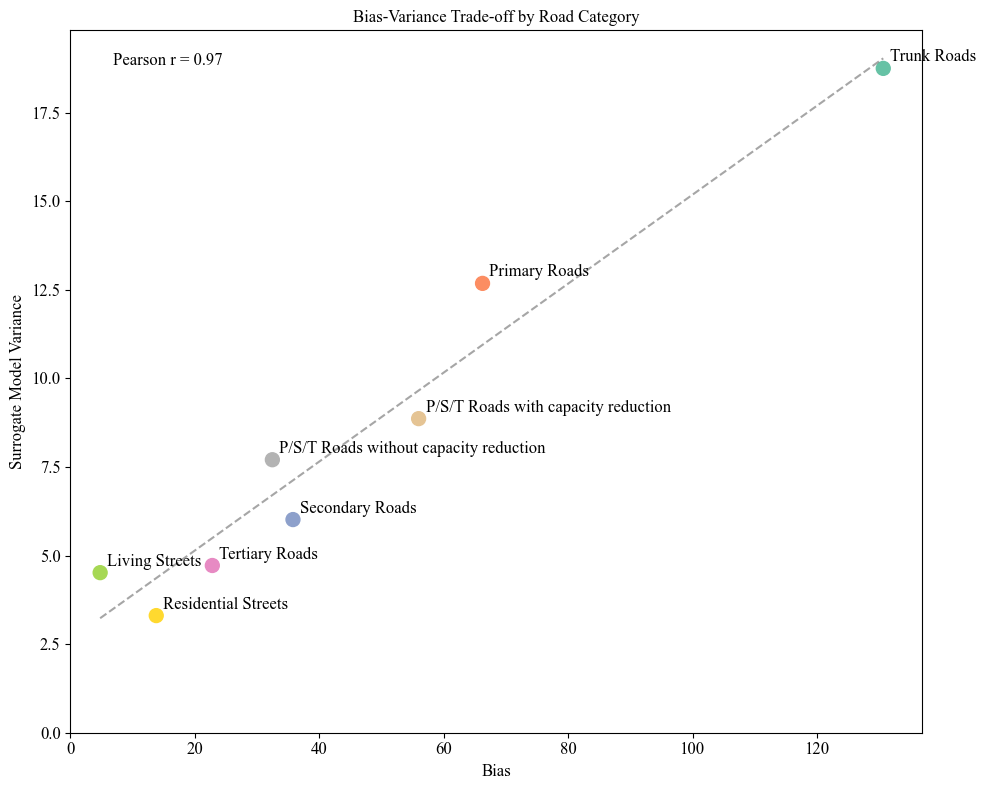

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd

plt.rcParams["font.family"] = "Times New Roman"

# Define road types
basic_road_types = ['trunk', 'primary', 'secondary', 'tertiary', 'living_street', 'residential']
pst_road_types = ['primary', 'secondary', 'tertiary']

# Collect results in a structured format
results = []

# First, add all basic road types (without distinguishing capacity reduction)
for highway_type in basic_road_types:
    description = highway_descriptions[highway_type]
    
    # Base mask for road type
    road_type_mask = gdf_with_og_values['highway'] == hf.highway_mapping[highway_type]
    if not road_type_mask.any():
        continue
        
    road_predictions = all_predictions_transposed[:, :, road_type_mask]
    road_predictions = road_predictions.reshape(5, -1)
    actuals_reshaped = all_actuals.reshape(831, -1)
    road_actuals = actuals_reshaped[:, road_type_mask].reshape(-1)
    
    road_bias, road_variance = compute_bias_variance(road_actuals, road_predictions)
    
    results.append({
        'Road Category': description,
        'Bias': road_bias,
        'Surrogate Model Variance': road_variance,
        'Total Error': road_bias + road_variance
    })

# Now add PST roads with and without capacity reduction
pst_mask = np.zeros(len(gdf_with_og_values), dtype=bool)
for highway_type in pst_road_types:
    pst_mask |= (gdf_with_og_values['highway'] == hf.highway_mapping[highway_type])

# With capacity reduction
with_reduction_mask = pst_mask & (gdf_with_og_values['capacity_reduction_rounded'] < 0)
road_predictions = all_predictions_transposed[:, :, with_reduction_mask]
road_predictions = road_predictions.reshape(5, -1)
actuals_reshaped = all_actuals.reshape(831, -1)
road_actuals = actuals_reshaped[:, with_reduction_mask].reshape(-1)
road_bias, road_variance = compute_bias_variance(road_actuals, road_predictions)
results.append({
    'Road Category': 'P/S/T Roads with capacity reduction',
    'Bias': road_bias,
    'Surrogate Model Variance': road_variance,
    'Total Error': road_bias + road_variance
})

# Without capacity reduction
without_reduction_mask = pst_mask & (gdf_with_og_values['capacity_reduction_rounded'] == 0)
road_predictions = all_predictions_transposed[:, :, without_reduction_mask]
road_predictions = road_predictions.reshape(5, -1)
actuals_reshaped = all_actuals.reshape(831, -1)
road_actuals = actuals_reshaped[:, without_reduction_mask].reshape(-1)
road_bias, road_variance = compute_bias_variance(road_actuals, road_predictions)
results.append({
    'Road Category': 'P/S/T Roads without capacity reduction',
    'Bias': road_bias,
    'Surrogate Model Variance': road_variance,
    'Total Error': road_bias + road_variance
})

# Convert to DataFrame for easier plotting
df_results = pd.DataFrame(results)

# Calculate Pearson correlation coefficient
correlation, p_value = stats.pearsonr(df_results['Bias'], df_results['Surrogate Model Variance'])

# plt.style.use('default')

# Create scatter plot
plt.figure(figsize=(10, 8))

plt.grid(False)
ax = plt.gca()
ax.set_axisbelow(False)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)

# Plot points
scatter = plt.scatter(df_results['Bias'], 
                     df_results['Surrogate Model Variance'],
                     c=[plt.cm.Set2(i) for i in range(len(df_results))],
                     s=100)

# Add trend line
z = np.polyfit(df_results['Bias'], df_results['Surrogate Model Variance'], 1)
p = np.poly1d(z)
x_trend = np.linspace(df_results['Bias'].min(), df_results['Bias'].max(), 100)
plt.plot(x_trend, p(x_trend), "gray", linestyle="--", alpha=0.7)

# Add correlation coefficient to plot
plt.text(0.05, 0.95, f'Pearson r = {correlation:.2f}', 
         transform=plt.gca().transAxes, 
         fontsize=12)

# Add labels for each point
for idx, row in df_results.iterrows():
    plt.annotate(row['Road Category'], 
                (row['Bias'], row['Surrogate Model Variance']),
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=12)

plt.xlabel('Bias', fontsize=12)
plt.ylabel('Surrogate Model Variance', fontsize=12)
# plt.title('Bias-Variance Trade-off by Road Category', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Set axes to start at 0
plt.xlim(left=0)
plt.ylim(bottom=0)

plt.tight_layout()
plt.savefig("bias_variance_tradeoff.png", dpi = 500)
plt.show()

In [ ]:
asdfa

In [24]:
def get_all_ensemble_predictions(data, device):
    """Get raw predictions from all ensemble members"""
    predictions = []
    
    for i, ensemble in enumerate(ensembles):
        model_path = os.path.join(runs_path, ensemble, 'trained_model/model.pth')
        model = load_ensemble(ensemble, model_path, use_dropout[i])
        model.eval()
        
        with torch.no_grad():
            pred = model(data.to(device))
            # Handle tuple output
            if isinstance(pred, tuple):
                pred = pred[0]  # Get first element of tuple
                if isinstance(pred, tuple):  # If still a tuple, get first element again
                    pred = pred[0]
            
            # Move to CPU and convert to numpy
            if torch.is_tensor(pred):
                pred = pred.cpu().numpy()
            
            predictions.append(pred)
    
    return np.array(predictions)

# Now try the uncertainty calculation
mean_uncertainties = []

print("Computing uncertainties across test set...")
for i in tqdm.tqdm(range(len(test_set_loader.dataset))):
    test_data = test_set_loader.dataset[i]
    ensemble_preds = get_all_ensemble_predictions(test_data, device)
    
    # Calculate standard deviation across ensemble predictions for each road
    uncertainty = np.std(ensemble_preds, axis=0)
    mean_uncertainties.append(uncertainty)

Computing uncertainties across test set...


 50%|████▉     | 412/831 [03:44<03:48,  1.83it/s]


TypeError: Dropout.forward() takes 2 positional arguments but 3 were given

In [26]:
# Test with one sample and all ensembles first
test_data = test_set_loader.dataset[0]

print("Testing predictions for each ensemble:")
for i, ensemble in enumerate(ensembles):
    model_path = os.path.join(runs_path, ensemble, 'trained_model/model.pth')
    model = load_ensemble(ensemble, model_path, use_dropout[i])
    model.eval()
    
    with torch.no_grad():
        pred = model(test_data.to(device))
        pred = pred.cpu().numpy()
        print(f"{ensemble}: prediction shape = {pred.shape}")

Testing predictions for each ensemble:
ensemble_1: prediction shape = (31635, 1)
ensemble_2: prediction shape = (31635, 1)
ensemble_3: prediction shape = (31635, 1)
ensemble_4_lrz: prediction shape = (31635, 1)
ensemble_5: prediction shape = (31635, 1)


Computing uncertainties across test set...


  0%|          | 0/831 [00:00<?, ?it/s]

100%|██████████| 831/831 [07:08<00:00,  1.94it/s]


25th Percentile: 0.8525
75th Percentile: 1.9240
Mean uncertainty: 1.5888
Max uncertainty: 23.3727


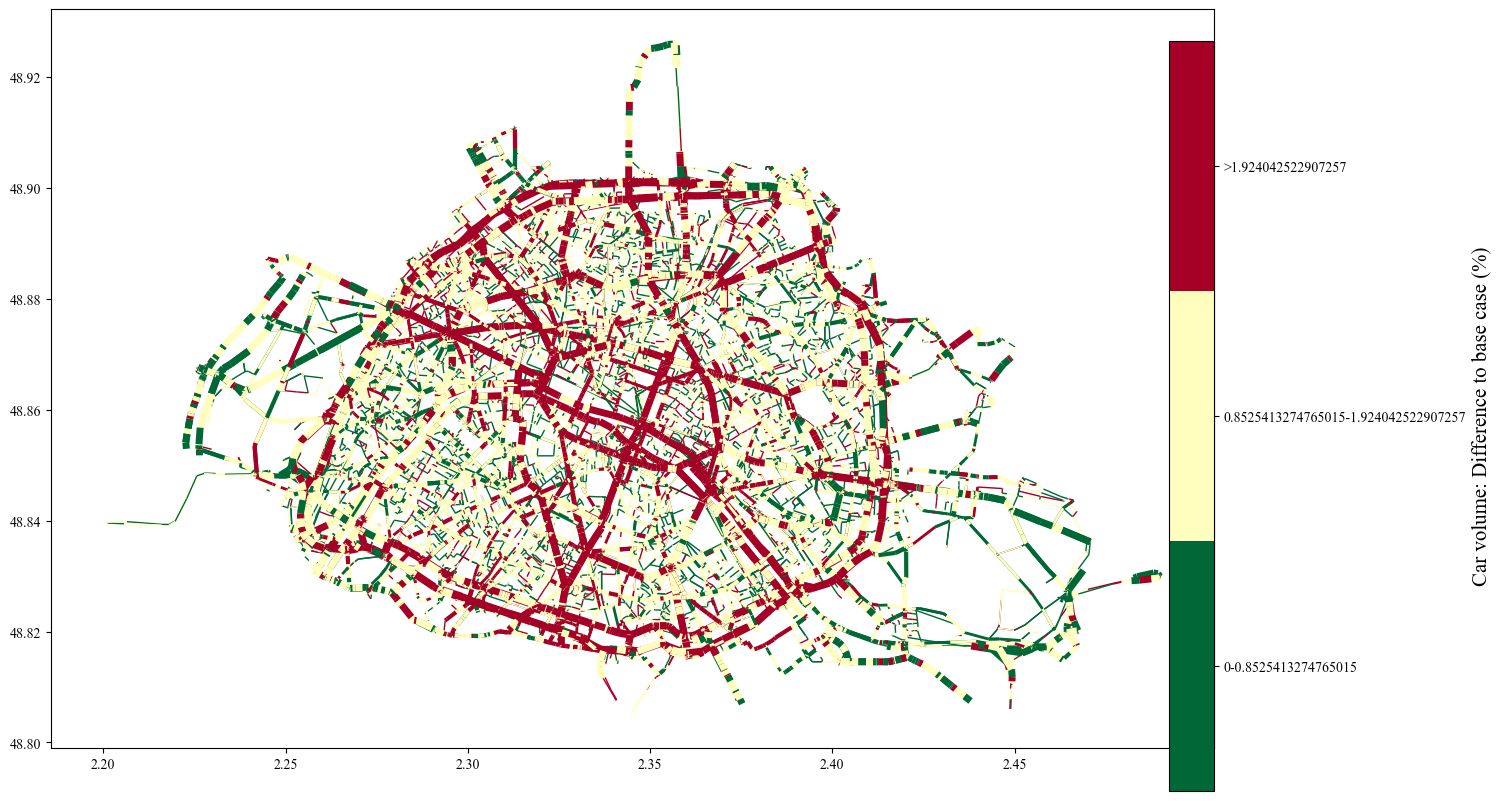

In [27]:
def get_all_ensemble_predictions(data, device):
    """Get raw predictions from all ensemble members"""
    predictions = []
    
    for i, ensemble in enumerate(ensembles):
        model_path = os.path.join(runs_path, ensemble, 'trained_model/model.pth')
        model = load_ensemble(ensemble, model_path, use_dropout[i])
        model.eval()
        
        with torch.no_grad():
            pred = model(data.to(device))
            pred = pred.cpu().numpy()
            predictions.append(pred)
    
    return np.array(predictions)  # This will be shape (n_ensembles, 31635, 1)

# Calculate uncertainties across test set
mean_uncertainties = []

print("Computing uncertainties across test set...")
for i in tqdm.tqdm(range(len(test_set_loader.dataset))):
    test_data = test_set_loader.dataset[i]
    ensemble_preds = get_all_ensemble_predictions(test_data, device)
    
    # Calculate standard deviation across ensemble predictions for each road
    uncertainty = np.std(ensemble_preds, axis=0)  # Take std across ensemble dimension
    mean_uncertainties.append(uncertainty)

# Average uncertainties across all test samples
mean_uncertainties = np.array(mean_uncertainties).mean(axis=0)

# Create visualization
flat_uc = np.sort(mean_uncertainties.flatten())
percentile_25 = np.percentile(flat_uc, 25)
percentile_75 = np.percentile(flat_uc, 75)

print(f"25th Percentile: {percentile_25:.4f}")
print(f"75th Percentile: {percentile_75:.4f}")
print(f"Mean uncertainty: {np.mean(flat_uc):.4f}")
print(f"Max uncertainty: {np.max(flat_uc):.4f}")

# Add uncertainties to the GeoDataFrame
gdf_with_og_values['ensemble_uncertainty'] = mean_uncertainties

# Plot with discrete color levels
discrete_thresholds = [percentile_25, percentile_75]

hf.plot_combined_output(
    gdf_input=gdf_with_og_values, 
    column_to_plot="ensemble_uncertainty",
    plot_contour_lines=False,
    save_it=False, 
    number_to_plot=1,
    zone_to_plot="this zone",
    is_predicted=True,
    use_fixed_norm=False,
    known_districts=False,
    buffer=0.0005,
    districts_of_interest=None,
    scale_type='discrete',
    discrete_thresholds=discrete_thresholds,
    cmap='Reds'
)

In [30]:
def get_all_ensemble_predictions(data, device):
    """Get raw predictions from all ensemble members"""
    predictions = []
    
    for i, ensemble in enumerate(ensembles):
        model_path = os.path.join(runs_path, ensemble, 'trained_model/model.pth')
        model = load_ensemble(ensemble, model_path, use_dropout[i])
        model.eval()
        
        with torch.no_grad():
            pred = model(data.to(device))
            pred = pred.cpu().numpy()
            predictions.append(pred)
    
    return np.array(predictions)

# Let's look at some example predictions and their relative uncertainties
test_data = test_set_loader.dataset[0]
ensemble_preds = get_all_ensemble_predictions(test_data, device)

print("Shape of ensemble predictions:", ensemble_preds.shape)
print("\nExample predictions for first 3 road segments:")
for i in range(3):
    road_preds = ensemble_preds[:, i, 0]  # predictions from all ensembles for road i
    mean_pred = np.mean(road_preds)
    abs_uncertainty = np.std(road_preds)
    rel_uncertainty = (abs_uncertainty / mean_pred) * 100  # as percentage
    print(f"\nRoad {i}:")
    print(f"Predictions from ensembles: {road_preds}")
    print(f"Mean prediction: {mean_pred:.3f}")
    print(f"Absolute uncertainty (std): {abs_uncertainty:.3f}")
    print(f"Relative uncertainty (CV): {rel_uncertainty:.1f}%")

# Now compute relative uncertainties for all roads
mean_relative_uncertainties = []

print("\nComputing relative uncertainties across test set...")
for i in tqdm.tqdm(range(len(test_set_loader.dataset))):
    test_data = test_set_loader.dataset[i]
    ensemble_preds = get_all_ensemble_predictions(test_data, device)
    
    # Calculate relative uncertainty (CV) for each road
    std_devs = np.std(ensemble_preds, axis=0)
    means = np.mean(ensemble_preds, axis=0)
    relative_uncertainties = (std_devs / means) * 100  # as percentage
    mean_relative_uncertainties.append(relative_uncertainties)

mean_relative_uncertainties = np.array(mean_relative_uncertainties).mean(axis=0)

# Create visualization
flat_uc = np.sort(mean_relative_uncertainties.flatten())
percentile_25 = np.percentile(flat_uc, 25)
percentile_75 = np.percentile(flat_uc, 75)

print("\nRelative Uncertainty Statistics:")
print(f"25th Percentile: {percentile_25:.1f}%")
print(f"75th Percentile: {percentile_75:.1f}%")
print(f"Mean relative uncertainty: {np.mean(flat_uc):.1f}%")
print(f"Max relative uncertainty: {np.max(flat_uc):.1f}%")

# Add relative uncertainties to the GeoDataFrame
gdf_with_og_values['ensemble_uncertainty'] = mean_relative_uncertainties

# Plot with discrete color levels
discrete_thresholds = [percentile_25, percentile_75]

hf.plot_combined_output(
    gdf_input=gdf_with_og_values, 
    column_to_plot="ensemble_uncertainty",
    plot_contour_lines=False,
    save_it=False, 
    number_to_plot=1,
    zone_to_plot="this zone",
    is_predicted=True,
    use_fixed_norm=False,
    known_districts=False,
    buffer=0.0005,
    districts_of_interest=None,
    scale_type='discrete',
    discrete_thresholds=discrete_thresholds,
    cmap='Reds'
)

Shape of ensemble predictions: (5, 31635, 1)

Example predictions for first 3 road segments:

Road 0:
Predictions from ensembles: [0.47552603 0.771513   0.37545094 0.95133406 1.6425701 ]
Mean prediction: 0.843
Absolute uncertainty (std): 0.449
Relative uncertainty (CV): 53.3%

Road 1:
Predictions from ensembles: [ -3.4943216  -12.646595    -0.76665103   0.9880914    1.5503939 ]
Mean prediction: -2.874
Absolute uncertainty (std): 5.193
Relative uncertainty (CV): -180.7%

Road 2:
Predictions from ensembles: [-1.0059133   0.01525595  0.56043804  1.267427    1.3731211 ]
Mean prediction: 0.442
Absolute uncertainty (std): 0.876
Relative uncertainty (CV): 198.3%

Computing relative uncertainties across test set...


 31%|███       | 256/831 [01:45<03:57,  2.42it/s]


TypeError: TransformerConv.forward() missing 1 required positional argument: 'edge_index'

In [32]:
# Test with one sample and print detailed information
test_data = test_set_loader.dataset[0]
predictions = []

print("Testing predictions for each ensemble:")
for i, ensemble in enumerate(ensembles):
    model_path = os.path.join(runs_path, ensemble, 'trained_model/model.pth')
    model = load_ensemble(ensemble, model_path, use_dropout[i])
    model.eval()
    
    with torch.no_grad():
        data = test_data.to(device)
        pred = model(data)
        pred_numpy = pred.cpu().numpy()
        predictions.append(pred_numpy)
        print(f"\n{ensemble}:")
        print(f"Prediction shape: {pred_numpy.shape}")
        print(f"Value range: [{pred_numpy.min():.2f}, {pred_numpy.max():.2f}]")

predictions = np.array(predictions)
print("\nFull predictions array shape:", predictions.shape)

# Test uncertainty calculation for a few roads
print("\nExample uncertainty calculations for first 3 roads:")
for i in range(3):
    road_preds = predictions[:, i, 0]  # all ensemble predictions for road i
    mean_pred = np.mean(road_preds)
    std_dev = np.std(road_preds)
    cv = (std_dev / mean_pred * 100) if mean_pred != 0 else 0
    
    print(f"\nRoad {i}:")
    print(f"Predictions: {road_preds}")
    print(f"Mean: {mean_pred:.2f}")
    print(f"Std Dev: {std_dev:.2f}")
    print(f"CV: {cv:.1f}%")

Testing predictions for each ensemble:

ensemble_1:
Prediction shape: (31635, 1)
Value range: [-212.58, 104.55]

ensemble_2:
Prediction shape: (31635, 1)
Value range: [-206.75, 71.58]

ensemble_3:
Prediction shape: (31635, 1)
Value range: [-203.55, 103.19]

ensemble_4_lrz:
Prediction shape: (31635, 1)
Value range: [-212.62, 87.47]

ensemble_5:
Prediction shape: (31635, 1)
Value range: [-209.18, 82.46]

Full predictions array shape: (5, 31635, 1)

Example uncertainty calculations for first 3 roads:

Road 0:
Predictions: [0.47552603 0.771513   0.37545094 0.95133406 1.6425701 ]
Mean: 0.84
Std Dev: 0.45
CV: 53.3%

Road 1:
Predictions: [ -3.4943216  -12.646595    -0.76665103   0.9880914    1.5503939 ]
Mean: -2.87
Std Dev: 5.19
CV: -180.7%

Road 2:
Predictions: [-1.0059133   0.01525586  0.56043804  1.267427    1.3731211 ]
Mean: 0.44
Std Dev: 0.88
CV: 198.3%


In [33]:
def get_all_ensemble_predictions(data, device):
    """Get raw predictions from all ensemble members"""
    predictions = []
    
    for i, ensemble in enumerate(ensembles):
        model_path = os.path.join(runs_path, ensemble, 'trained_model/model.pth')
        model = load_ensemble(ensemble, model_path, use_dropout[i])
        model.eval()
        
        with torch.no_grad():
            data = data.to(device)
            pred = model(data)
            pred = pred.cpu().numpy()
            predictions.append(pred)
    
    return np.array(predictions)

# Now compute uncertainties using a more robust measure
mean_uncertainties = []

print("\nComputing uncertainties across test set...")
for i in tqdm.tqdm(range(len(test_set_loader.dataset))):
    test_data = test_set_loader.dataset[i]
    ensemble_preds = get_all_ensemble_predictions(test_data, device)
    
    # Calculate uncertainty as the range of predictions
    # (max - min) / (|mean| + epsilon) to handle zeros and negative values
    max_preds = np.max(ensemble_preds, axis=0)
    min_preds = np.min(ensemble_preds, axis=0)
    mean_preds = np.mean(ensemble_preds, axis=0)
    epsilon = 1.0  # small constant to avoid division by zero and handle small values
    
    uncertainty = (max_preds - min_preds) / (np.abs(mean_preds) + epsilon)
    mean_uncertainties.append(uncertainty)

mean_uncertainties = np.array(mean_uncertainties).mean(axis=0)

# Print some statistics
print("\nUncertainty Statistics:")
print(f"Mean uncertainty: {np.mean(mean_uncertainties):.3f}")
print(f"Max uncertainty: {np.max(mean_uncertainties):.3f}")
print(f"Min uncertainty: {np.min(mean_uncertainties):.3f}")

# Add uncertainties to the GeoDataFrame
gdf_with_og_values['ensemble_uncertainty'] = mean_uncertainties

# Plot with discrete color levels
percentile_25 = np.percentile(mean_uncertainties, 25)
percentile_75 = np.percentile(mean_uncertainties, 75)
discrete_thresholds = [percentile_25, percentile_75]

hf.plot_combined_output(
    gdf_input=gdf_with_og_values, 
    column_to_plot="ensemble_uncertainty",
    plot_contour_lines=False,
    save_it=False, 
    number_to_plot=1,
    zone_to_plot="this zone",
    is_predicted=True,
    use_fixed_norm=False,
    known_districts=False,
    buffer=0.0005,
    districts_of_interest=None,
    scale_type='discrete',
    discrete_thresholds=discrete_thresholds,
    cmap='Reds'
)


Computing uncertainties across test set...


 22%|██▏       | 179/831 [01:12<04:23,  2.47it/s]


TypeError: Dropout.forward() takes 2 positional arguments but 3 were given

In [36]:
def get_all_ensemble_predictions(data, device):
    """Get raw predictions from all ensemble members"""
    predictions = []
    
    for i, ensemble in enumerate(ensembles):
        model_path = os.path.join(runs_path, ensemble, 'trained_model/model.pth')
        model = load_ensemble(ensemble, model_path, use_dropout[i])
        model.eval()
        
        # Use mc_dropout_predict and handle tuple output
        pred = mc_dropout_predict(model, data.to(device))
        if isinstance(pred, tuple):
            pred = pred[0]  # Get first element of tuple
        # No need for cpu() since it's already numpy
        predictions.append(pred)
    
    return np.array(predictions)

# Test with one sample first
test_data = test_set_loader.dataset[0]
try:
    ensemble_preds = get_all_ensemble_predictions(test_data, device)
    print("Test prediction shape:", ensemble_preds.shape)
    print("Test prediction range:", ensemble_preds.min(), "to", ensemble_preds.max())
except Exception as e:
    print("Error:", e)

Test prediction shape: (5, 31635, 1)
Test prediction range: -212.6195 to 104.548874


In [37]:
# Now compute uncertainties using a robust measure
mean_uncertainties = []

print("\nComputing uncertainties across test set...")
for i in tqdm.tqdm(range(len(test_set_loader.dataset))):
    test_data = test_set_loader.dataset[i]
    ensemble_preds = get_all_ensemble_predictions(test_data, device)
    
    # Calculate uncertainty as the range of predictions
    # (max - min) / (|mean| + epsilon) to handle zeros and negative values
    max_preds = np.max(ensemble_preds, axis=0)
    min_preds = np.min(ensemble_preds, axis=0)
    mean_preds = np.mean(ensemble_preds, axis=0)
    epsilon = 1.0  # small constant to avoid division by zero and handle small values
    
    uncertainty = (max_preds - min_preds) / (np.abs(mean_preds) + epsilon)
    mean_uncertainties.append(uncertainty)

mean_uncertainties = np.array(mean_uncertainties).mean(axis=0)

# Print some statistics
print("\nUncertainty Statistics:")
print(f"Mean uncertainty: {np.mean(mean_uncertainties):.3f}")
print(f"Max uncertainty: {np.max(mean_uncertainties):.3f}")
print(f"Min uncertainty: {np.min(mean_uncertainties):.3f}")

# Add uncertainties to the GeoDataFrame
gdf_with_og_values['ensemble_uncertainty'] = mean_uncertainties

# Plot with discrete color levels
percentile_25 = np.percentile(mean_uncertainties, 25)
percentile_75 = np.percentile(mean_uncertainties, 75)
discrete_thresholds = [percentile_25, percentile_75]

hf.plot_combined_output(
    gdf_input=gdf_with_og_values, 
    column_to_plot="ensemble_uncertainty",
    plot_contour_lines=False,
    save_it=False, 
    number_to_plot=1,
    zone_to_plot="this zone",
    is_predicted=True,
    use_fixed_norm=False,
    known_districts=False,
    buffer=0.0005,
    districts_of_interest=None,
    scale_type='discrete',
    discrete_thresholds=discrete_thresholds,
    cmap='Reds'
)


Computing uncertainties across test set...


 91%|█████████ | 753/831 [1:07:20<06:58,  5.37s/it]


TypeError: Dropout.forward() takes 2 positional arguments but 3 were given

In [45]:
def get_all_ensemble_predictions(data, device):
    """Get raw predictions from all ensemble members"""
    predictions = []
    
    for i, ensemble in enumerate(ensembles):
        model_path = os.path.join(runs_path, ensemble, 'trained_model/model.pth')
        model = load_ensemble(ensemble, model_path, use_dropout[i])
        model.eval()
        
        # Use the existing mc_dropout_predict function with num_samples=1
        pred = mc_dropout_predict(model, data, num_samples=1, device=device)
        if isinstance(pred, tuple):
            pred = pred[0]
        predictions.append(pred)
    
    return np.array(predictions)

# Now compute uncertainties using a robust measure
mean_uncertainties = []

print("\nComputing uncertainties across test set...")
for i in tqdm.tqdm(range(len(test_set_loader.dataset))):
    test_data = test_set_loader.dataset[i]
    ensemble_preds = get_all_ensemble_predictions(test_data, device)
    
    # Calculate uncertainty as the range of predictions
    # (max - min) / (|mean| + epsilon) to handle zeros and negative values
    max_preds = np.max(ensemble_preds, axis=0)
    min_preds = np.min(ensemble_preds, axis=0)
    mean_preds = np.mean(ensemble_preds, axis=0)
    epsilon = 1.0  # small constant to avoid division by zero and handle small values
    
    uncertainty = (max_preds - min_preds) / (np.abs(mean_preds) + epsilon)
    mean_uncertainties.append(uncertainty)

mean_uncertainties = np.array(mean_uncertainties).mean(axis=0)

# Print some statistics
print("\nUncertainty Statistics:")
print(f"Mean uncertainty: {np.mean(mean_uncertainties):.3f}")
print(f"Max uncertainty: {np.max(mean_uncertainties):.3f}")
print(f"Min uncertainty: {np.min(mean_uncertainties):.3f}")

# Add uncertainties to the GeoDataFrame
gdf_with_og_values['ensemble_uncertainty'] = mean_uncertainties

# Plot with discrete color levels
percentile_25 = np.percentile(mean_uncertainties, 25)
percentile_75 = np.percentile(mean_uncertainties, 75)
discrete_thresholds = [percentile_25, percentile_75]

hf.plot_combined_output(
    gdf_input=gdf_with_og_values, 
    column_to_plot="ensemble_uncertainty",
    plot_contour_lines=False,
    save_it=False, 
    number_to_plot=1,
    zone_to_plot="this zone",
    is_predicted=True,
    use_fixed_norm=False,
    known_districts=False,
    buffer=0.0005,
    districts_of_interest=None,
    scale_type='discrete',
    discrete_thresholds=discrete_thresholds,
    cmap='Reds'
)


Computing uncertainties across test set...


  0%|          | 0/831 [00:00<?, ?it/s]

 14%|█▍        | 119/831 [00:48<04:49,  2.46it/s]


TypeError: TransformerConv.forward() missing 1 required positional argument: 'edge_index'

### Next, we will look at the test set and visualize the performance of the ensembles.

In [6]:
links_base_case = gpd.read_file(base_case_path, crs="EPSG:4326")

In [ ]:
# Visualize performance of individual models

fixed_norm_max = 8
i = 0

print(f"Results for sample {i}\n")

test_data = test_set_loader.dataset[i]
test_x = test_set_loader.dataset[i].x
test_x = test_x.to('cpu')

for i, ensemble in enumerate(ensembles):

    print(f"Results for {ensemble}:")

    model_path = os.path.join(runs_path,ensemble,'trained_model/model.pth')
    model = load_ensemble(ensemble, model_path, use_dropout[i])

    test_loss, r_squared, actual_vals, predictions, baseline_loss = hf.validate_model_on_test_set(model, test_data, loss_fct, device)

    print(f"Test Loss: {test_loss}")
    print(f"R-squared: {r_squared}")
    print(f"Baseline Loss: {baseline_loss}")

    inversed_x = scaler_x.inverse_transform(test_x)

    # print(f"Length of original_gdf: {len(links_base_case)}")
    # print(f"Length of inversed_x: {inversed_x.shape[0]}")

    gdf_with_og_values = hf.data_to_geodataframe_with_og_values(data=test_data, original_gdf=links_base_case, predicted_values=predictions, inversed_x=inversed_x, use_all_features=False)
    gdf_with_og_values['capacity_reduction_rounded'] = gdf_with_og_values['capacity_reduction'].round(decimals=3)
    gdf_with_og_values['highway'] = gdf_with_og_values['highway'].map(hf.highway_mapping)

    # print("\nPredicted values:")
    # hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_change_predicted", 
    #                         save_it=False, number_to_plot=i, zone_to_plot = "this zone", is_predicted=True, alpha=0, 
    #                         use_fixed_norm=False, fixed_norm_max = fixed_norm_max,
    #                         known_districts = False, buffer = 0.0005, 
    #                         plot_policy_roads = True, 
    #                         plot_contour_lines = True, 
    #                         districts_of_interest=None)

    # print("Actual values:")
    # hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="vol_car_change_actual", save_it=False, 
    #                         number_to_plot=i, zone_to_plot = "this zone",is_predicted=False,alpha=10,
    #                         use_fixed_norm=False, fixed_norm_max = fixed_norm_max,
    #                         known_districts = False, buffer = 0.0005, 
    #                         plot_policy_roads = True, 
    #                         plot_contour_lines = True, 
    #                         districts_of_interest=None)
    
    
    break

Results for sample 0

Results for ensemble_1:
Test Loss: 4.103627068655832
R-squared: 0.8248999118804932
Baseline Loss: 164.05125427246094


/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [8]:
def ensemble_predict(model, data, device):
    
    predictions = []

    with torch.no_grad():
        for i, ensemble in enumerate(ensembles):
            
            model_path = os.path.join(runs_path, ensemble, 'trained_model/model.pth')
            model = load_ensemble(ensemble, model_path, use_dropout[i])
            model.eval()

            pred = model(data.to(device))
            if isinstance(pred, tuple):  # If multiple outputs (e.g., mode_stats)
                pred = pred[0]
            predictions.append(pred.cpu().numpy())  # Collect predictions

    # Stack predictions and calculate statistics
    predictions = np.stack(predictions, axis=0)  # Shape: (num_ensembles, num_predictions)
    mean_prediction = predictions.mean(axis=0)  # Mean prediction
    uncertainty = predictions.std(axis=0)       # Uncertainty (standard deviation)

    return mean_prediction, uncertainty

Ensemble uncertainty for sample 32:


/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


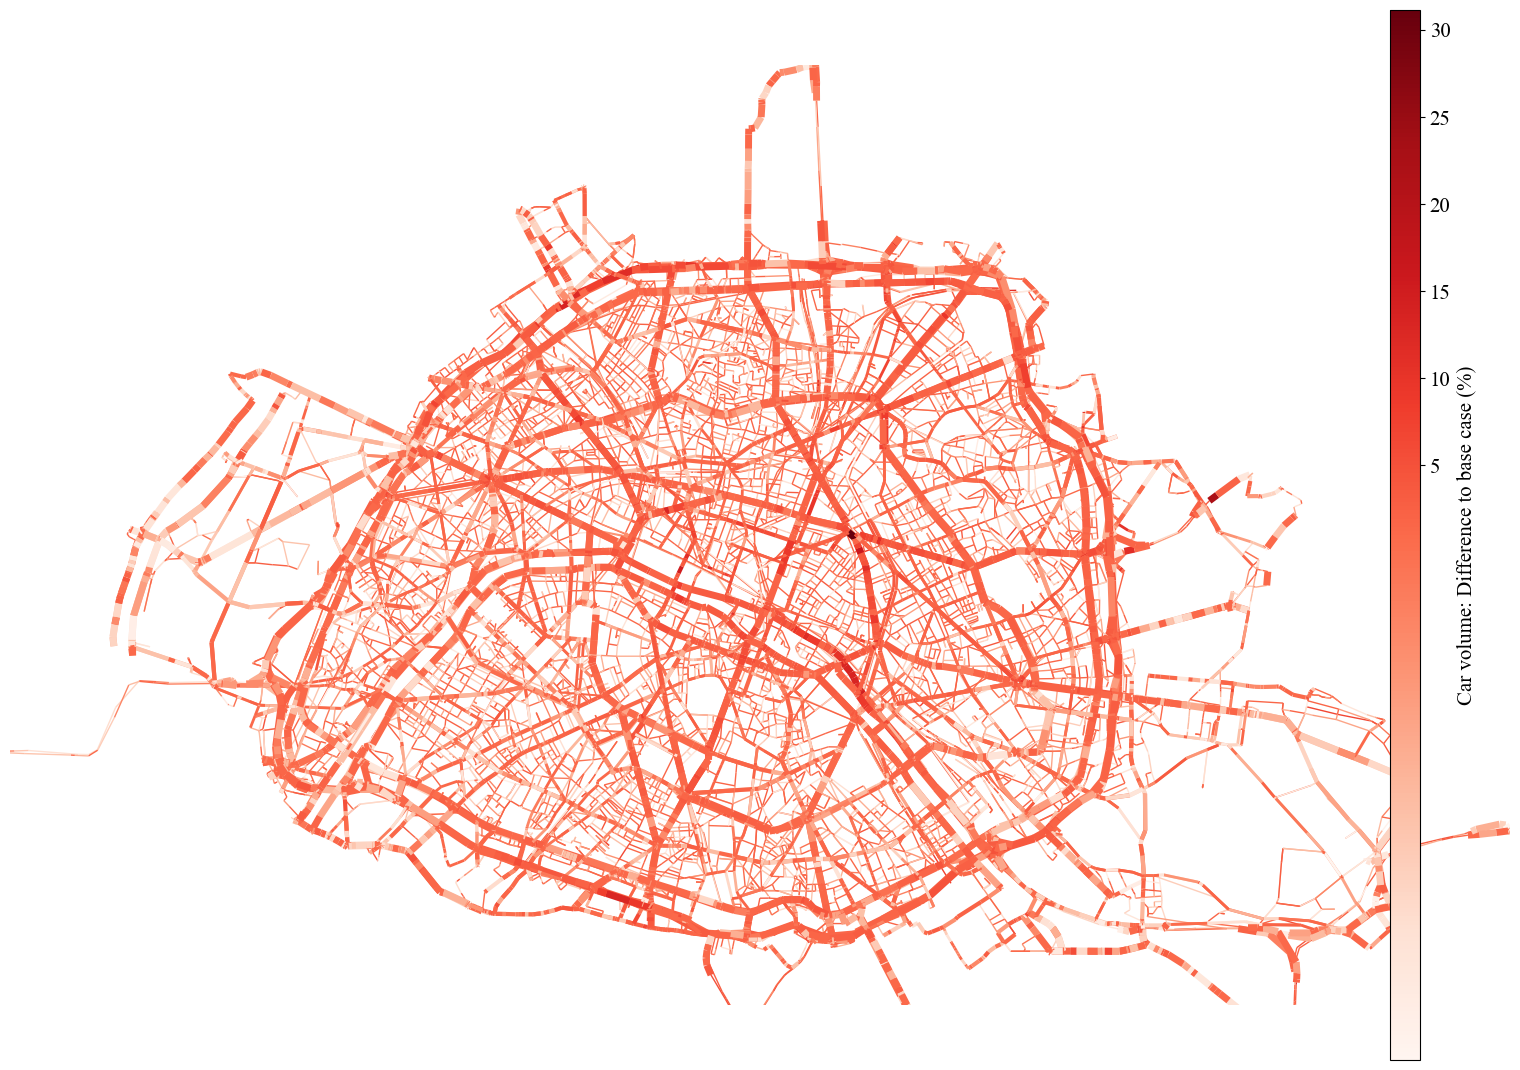

In [ ]:
# Ensemble uncertainty on single sample

i = 32
print(f"Ensemble uncertainty for sample {i}:")

test_data = test_set_loader.dataset[i]
test_x = test_set_loader.dataset[i].x
test_x = test_x.to('cpu')

inversed_x = scaler_x.inverse_transform(test_x)
mean_predictions, uncertainties = ensemble_predict(model, test_data, device=device)

gdf_with_og_values = hf.data_to_geodataframe_with_og_values(data=test_data, original_gdf=links_base_case, predicted_values=mean_predictions, inversed_x=inversed_x, use_all_features=False)
gdf_with_og_values['capacity_reduction_rounded'] = gdf_with_og_values['capacity_reduction'].round(decimals=3)
gdf_with_og_values['highway'] = gdf_with_og_values['highway'].map(hf.highway_mapping)
gdf_with_og_values['ensemble_uncertainty'] = uncertainties

hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="ensemble_uncertainty", plot_contour_lines=False,
                        save_it=False, number_to_plot=i, zone_to_plot = "this zone", is_predicted=True, use_fixed_norm=False,
                        known_districts = False, buffer = 0.0005, districts_of_interest=None, cmap='Reds')

In [10]:
# Ensemble uncertainty on entire test set

mean_uncertainties = []

for i in tqdm.tqdm(range(len(test_set_loader.dataset))):
    
    test_data = test_set_loader.dataset[i]
    test_x = test_set_loader.dataset[i].x
    test_x = test_x.to('cpu')

    mean_predictions, uncertainties = ensemble_predict(model, test_data, device=device)
    mean_uncertainties.append(uncertainties)

mean_uncertainties = np.array(mean_uncertainties).mean(axis=0)

  0%|          | 0/831 [00:00<?, ?it/s]/opt/anaconda3/envs/chenhao-gnn/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 831/831 [05:36<00:00,  2.47it/s]


In [11]:
# Some stats to pick discrete bins
import numpy as np

flat_uc = np.sort(mean_uncertainties.flatten())

percentile_1 = np.percentile(flat_uc, 25)
percentile_2 = np.percentile(flat_uc, 75)

print(f"1st Percentile: {percentile_1}")
print(f"2nd Percentile: {percentile_2}")

1st Percentile: 0.8525413274765015
2nd Percentile: 1.924042522907257


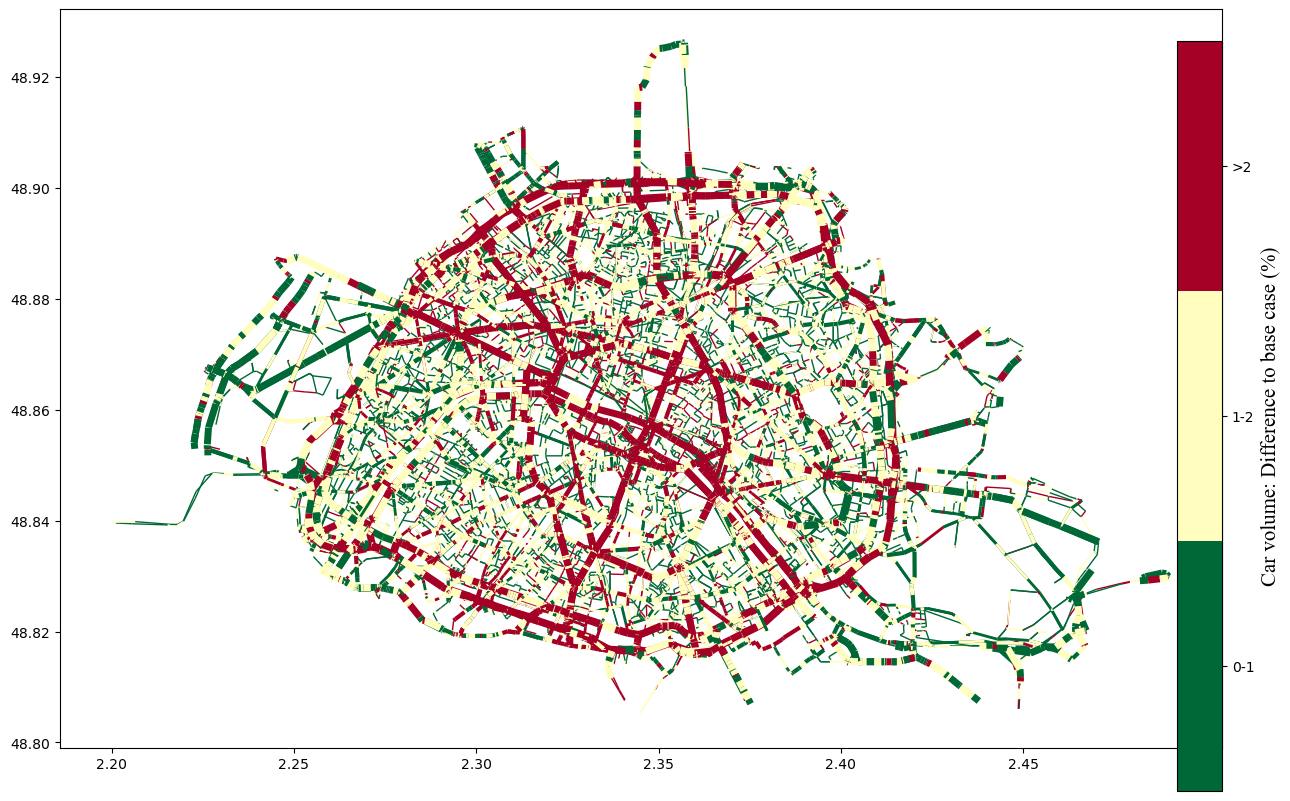

In [ ]:
# On the last sample, but does not matter
inversed_x = scaler_x.inverse_transform(test_x)
gdf_with_og_values = hf.data_to_geodataframe_with_og_values(data=test_data, original_gdf=links_base_case, predicted_values=mean_predictions, inversed_x=inversed_x, use_all_features=False)
gdf_with_og_values['capacity_reduction_rounded'] = gdf_with_og_values['capacity_reduction'].round(decimals=3)
gdf_with_og_values['highway'] = gdf_with_og_values['highway'].map(hf.highway_mapping)
gdf_with_og_values['ensemble_uncertainty'] = mean_uncertainties

dicrete_thresholds = [1,2]

hf.plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="ensemble_uncertainty", plot_contour_lines=False,
                        save_it=False, number_to_plot=i+1, zone_to_plot = "this zone", is_predicted=True, use_fixed_norm=False,
                        known_districts = False, buffer = 0.0005, districts_of_interest=None, scale_type='discrete', discrete_thresholds=dicrete_thresholds)

In [13]:
# Uncertainty by road type
highway_descriptions = {
    0: 'trunk',
    1: 'primary',
    2: 'secondary',
    3: 'tertiary',
    4: 'residential',
    5: 'living streets',
    6: 'pedestrian',
    7: 'service',
    8: 'construction',
    9: 'unclassified',
    'all_types': 'all types'
}

# Calculate mean uncertainty by highway type
mean_uncertainty_by_highway = gdf_with_og_values.groupby('highway')['ensemble_uncertainty'].mean()

# Calculate mean uncertainty for all types
mean_uncertainty_all_types = gdf_with_og_values['ensemble_uncertainty'].mean()
mean_uncertainty_by_highway['all_types'] = mean_uncertainty_all_types

# Map highway descriptions
mean_uncertainty_by_highway.index = mean_uncertainty_by_highway.index.map(highway_descriptions)

print(mean_uncertainty_by_highway)

highway
trunk             2.661694
primary           2.305066
secondary         1.728441
tertiary          1.517441
residential       1.285359
living streets    1.236011
pedestrian        1.387281
service           1.508442
construction      1.352515
unclassified      1.406624
all types         1.588820
Name: ensemble_uncertainty, dtype: float32
